In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style = "darkgrid")

from src.ClusteringPrototypiqueTemporel import ClusteringPrototypiqueTemporel

In [2]:
def generate_client(low: int = 1, high: int = 1000, size = 300):
    initial_value = np.random.randint(low = low, high = high)
    values = np.random.randint(low = np.max([0, int(initial_value - .4 * initial_value)]), 
                           high= initial_value + .4 * initial_value, 
                           size = size - 1)
    return np.hstack([initial_value, values.ravel()]).ravel()

In [3]:
# Génération du dataframe
achats = dict()
for i in range(500):
    achats[f"client {i}"] = generate_client()
    
clients_dataframe = pd.DataFrame.from_dict(achats)

# Moyenne mobile sur 30 valeurs pour tuer le bruit
clients_dataframe = clients_dataframe.rolling(30).mean().dropna(axis = 0).reset_index(drop = True)
clients_dataframe.index = pd.date_range(start = "2001-01-01", periods=clients_dataframe.shape[0], freq="m").tolist()

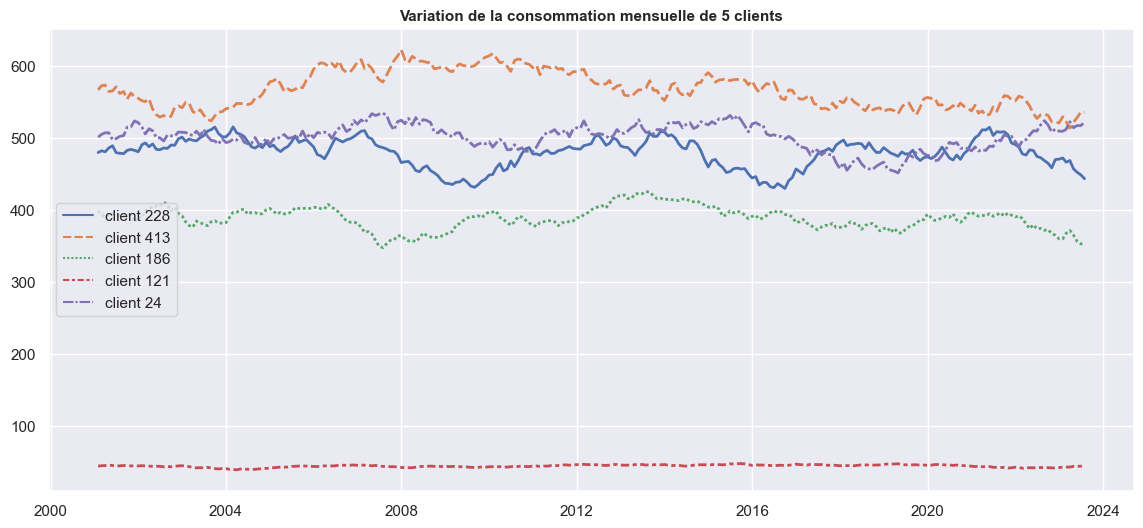

In [4]:
plt.figure(figsize = (14, 6))
plt.title("Variation de la consommation mensuelle de 5 clients", fontsize = 11, fontweight = "bold")
sns.lineplot(clients_dataframe[[x for x in np.random.choice(clients_dataframe.columns, 5)]], lw = 2)
plt.show()

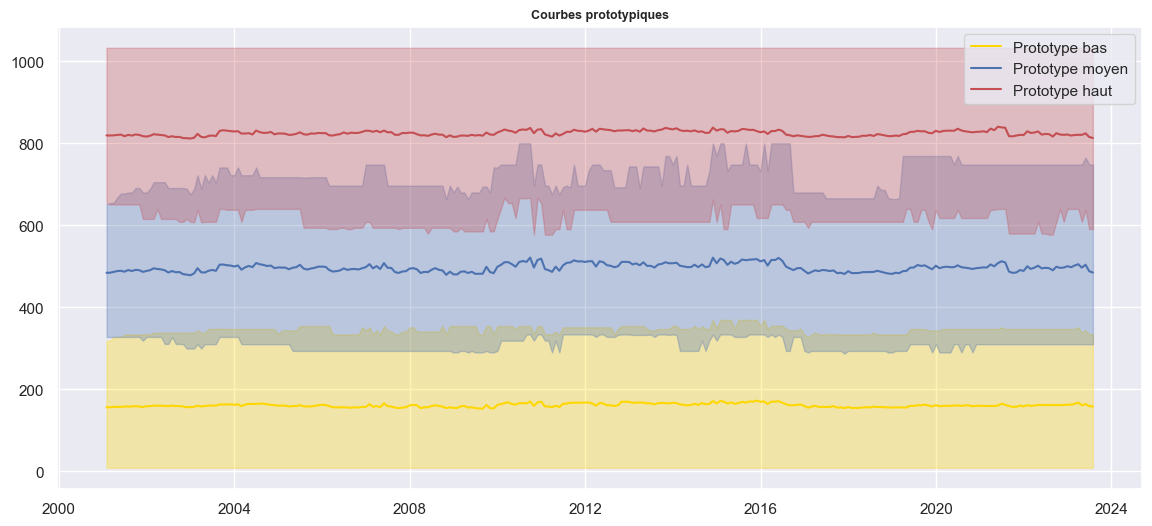

In [5]:
clusters = ClusteringPrototypiqueTemporel(clients_dataframe)
clusters.fit()
clusters.plot_prototypes()

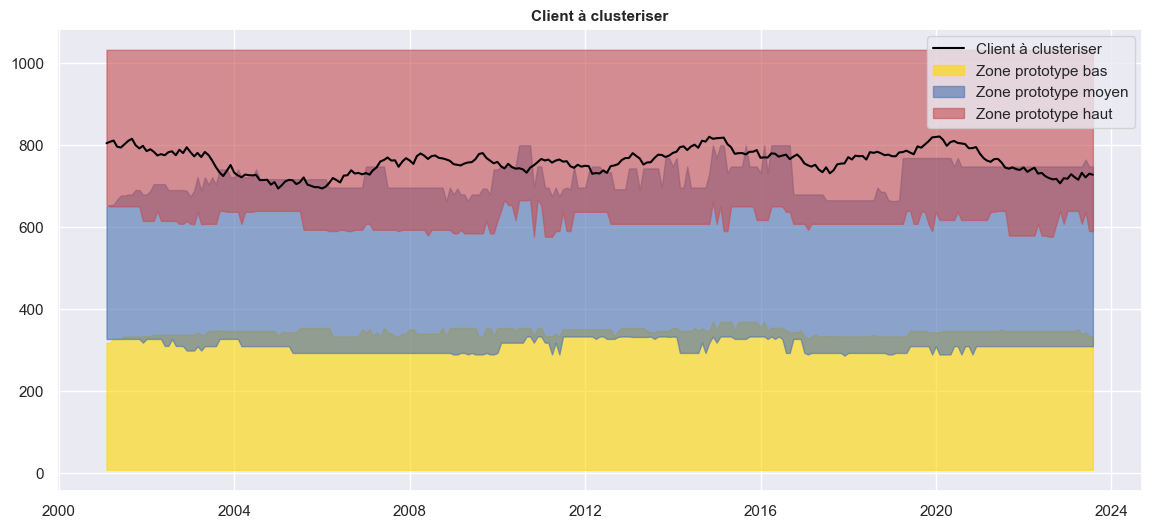

Prédiction : Prototype haut


In [6]:
new_client = generate_client()
new_client = pd.Series(new_client).rolling(30).mean().dropna(axis = 0).reset_index(drop = True)
new_client.index = clients_dataframe.index

clusters.plot_and_predict(new_client)

### Prédiction des courbes prototypiques

In [7]:
serie_basse = clusters.get_prototypes()["prototype_faible"]["Moyenne"]
serie_moyenne = clusters.get_prototypes()["prototype_moyen"]["Moyenne"]
serie_haute = clusters.get_prototypes()["prototype_fort"]["Moyenne"]

In [8]:
import statsmodels.api as sm

model = sm.tsa.statespace.SARIMAX(endog = serie_basse, order = (3, 1, 0), seasonal_order = (2, 1, 0, 12))
fitted_model_bas = model.fit()

model = sm.tsa.statespace.SARIMAX(endog = serie_moyenne, order = (3, 1, 0), seasonal_order = (2, 1, 0, 12))
fitted_model_moyen = model.fit()

model = sm.tsa.statespace.SARIMAX(endog = serie_haute, order = (3, 1, 0), seasonal_order = (2, 1, 0, 12))
fitted_model_haut = model.fit()

In [9]:
forecast_bas = fitted_model_bas.forecast(30)
forecast_moyen = fitted_model_moyen.forecast(30)
forecast_haut = fitted_model_haut.forecast(30)

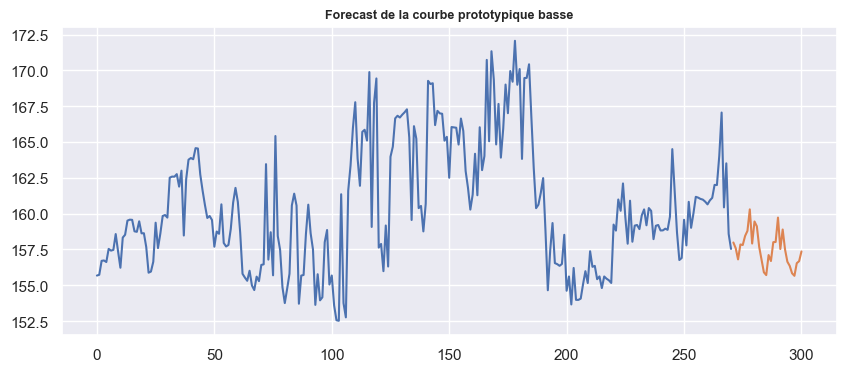

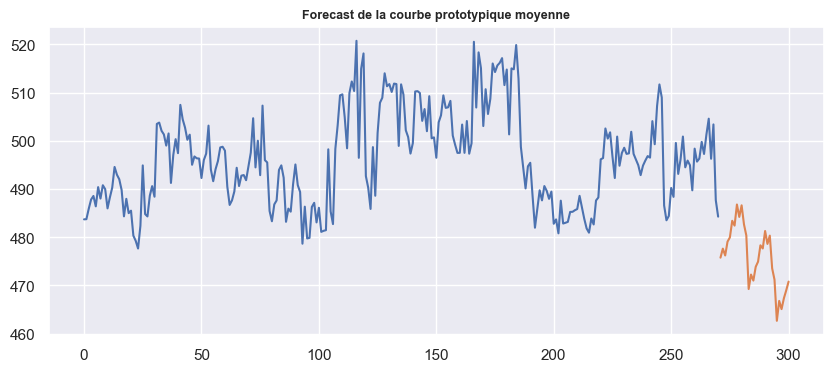

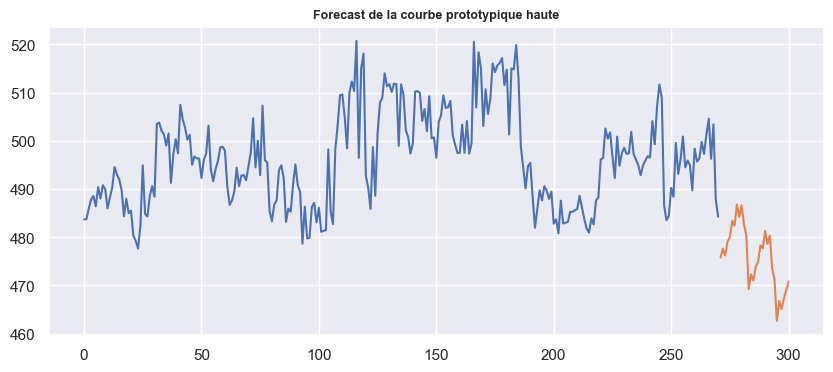

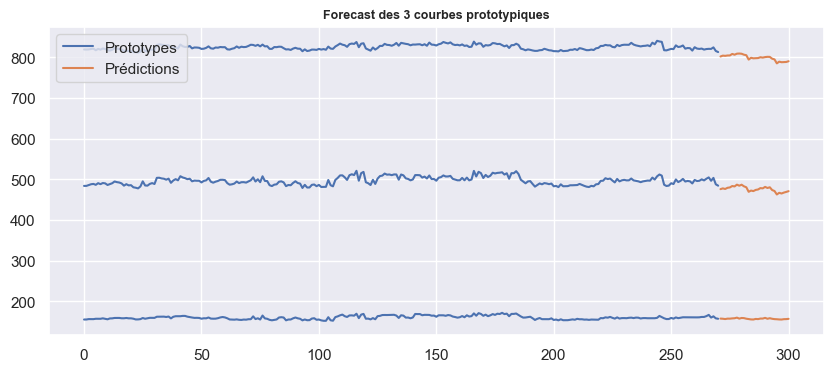

In [10]:
plt.figure(figsize = (10, 4))
plt.title("Forecast de la courbe prototypique basse", fontsize = 9, fontweight = "bold")
plt.plot(serie_basse, label = "Prototypes", color = "C0")
plt.plot(forecast_bas, label = "Prédictions", color = "C1")
plt.show()

plt.figure(figsize = (10, 4))
plt.title("Forecast de la courbe prototypique moyenne", fontsize = 9, fontweight = "bold")
plt.plot(serie_moyenne, color = "C0")
plt.plot(forecast_moyen, color = "C1")
plt.show()

plt.figure(figsize = (10, 4))
plt.title("Forecast de la courbe prototypique haute", fontsize = 9, fontweight = "bold")
plt.plot(serie_moyenne, color = "C0")
plt.plot(forecast_moyen, color = "C1")
plt.show()

plt.figure(figsize = (10, 4))
plt.title("Forecast des 3 courbes prototypiques", fontsize = 9, fontweight = "bold")
plt.plot(serie_haute, color = "C0")
plt.plot(forecast_haut, color = "C1")

plt.plot(serie_basse, label = "Prototypes", color = "C0")
plt.plot(forecast_bas, label = "Prédictions", color = "C1")

plt.plot(serie_moyenne, color = "C0")
plt.plot(forecast_moyen, color = "C1")

plt.legend()
plt.show()